In [1]:
import sys
sys.path.append('/home/frank_regal/regal_docker_dev/HRI-Cacti/project/ws_dev/src/hri_cacti_xr/gesture_recognition/research/lang-segment-anything/lang_sam')

In [2]:
%pip install groundingdino-py git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-kaoeqv9g
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-kaoeqv9g
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 526fd066dea338ba2ca08886853bd37ffd6a8aec
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [3]:
from PIL import Image
import numpy as np
from lang_sam import LangSAM
import lang_sam.utils as lsu
import matplotlib.pyplot as plt
import cv2
import io
import os
import warnings

In [4]:
warnings.filterwarnings("ignore")
model = LangSAM()

final text_encoder_type: bert-base-uncased
Model loaded from /home/frank_regal/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


IoU between body box 0 and arm box 0: 0.0594
IoU between body box 1 and arm box 0: 0.0000


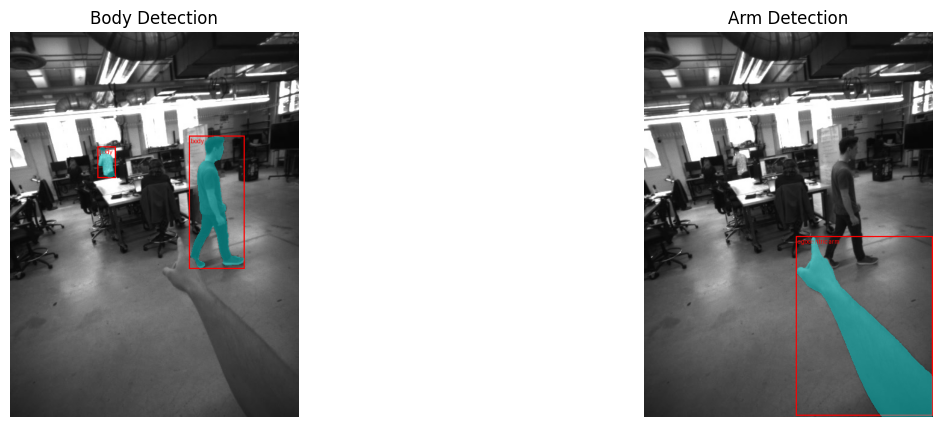

In [21]:
image_pil = Image.open("/home/frank_regal/regal_docker_dev/HRI-Cacti/project/ws_dev/src/hri_cacti_xr/gesture_recognition/research/lang-segment-anything/my_playground/00017.jpg").convert("RGB")
# image_pil = Image.open("/home/frank_regal/regal_docker_dev/HRI-Cacti/project/ws_dev/src/hri_cacti_xr/data/005_data/devices/mono_lf/frames/Deictic/S0507162338-D002-C003/00008.jpg").convert("RGB")
# image_pil = Image.open("/home/frank_regal/regal_docker_dev/HRI-Cacti/project/ws_dev/src/hri_cacti_xr/gesture_recognition/first_person_pov/prep/test_data/one_device/mono_rr/frames/Advance/S0506220418-D004-C001/00005.jpg").convert("RGB")

text_prompt_body = "body"
masks_body, boxes_body, phrases_body, logits_body = model.predict(image_pil, text_prompt_body)

text_prompt_arm = "egocentric arm"
masks_arm, boxes_arm, phrases_arm, logits_arm = model.predict(image_pil, text_prompt_arm)


# Calculate IoU for each pair of boxes
def calculate_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2
    
    # Calculate intersection area
    inter_x1 = max(x1, x3)
    inter_y1 = max(y1, y3)
    inter_x2 = min(x2, x4)
    inter_y2 = min(y2, y4)
    
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    
    # Calculate union area
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x4 - x3) * (y4 - y3)
    union_area = box1_area + box2_area - inter_area
    
    # Calculate IoU
    iou = inter_area / union_area if union_area > 0 else 0
    return iou

for i, box_body in enumerate(boxes_body):
    for j, box_arm in enumerate(boxes_arm):
        iou = calculate_iou(box_body, box_arm)
        print(f"IoU between body box {i} and arm box {j}: {iou:.4f}")

image_rgb = np.array(image_pil)
image_body = lsu.draw_image(image_rgb.copy(), masks_body, boxes_body, phrases_body)
image_arm = lsu.draw_image(image_rgb.copy(), masks_arm, boxes_arm, phrases_arm)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.imshow(image_body)
ax1.set_title("Body Detection")
ax1.axis('off')
ax2.imshow(image_arm)
ax2.set_title("Arm Detection")
ax2.axis('off')
plt.show()

In [ ]:
def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)
    
def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i, mask_np in enumerate(masks):
        axes[i+1].imshow(mask_np, cmap='gray')
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)
    
def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i, mask_np in enumerate(masks):
        axes[i+1].imshow(mask_np, cmap='gray')
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def display_image_with_boxes(image, boxes, logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis('off')

    for box, logit in zip(boxes, logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(logit.item(), 2)  # Convert logit to a scalar before rounding
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

        # Add confidence score as text
        ax.text(x_min, y_min, f"Confidence: {confidence_score}", fontsize=8, color='red', verticalalignment='top')

    plt.show()

def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")

def print_detected_phrases(phrases):
    print("\nDetected Phrases:")
    for i, phrase in enumerate(phrases):
        print(f"Phrase {i+1}: {phrase}")

def print_logits(logits):
    print("\nConfidence:")
    for i, logit in enumerate(logits):
        print(f"Logit {i+1}: {logit}")
        
# Utility func to count num files in directory
def CountFiles(Directory):
    return len([name for name in os.listdir(Directory) if os.path.isfile(os.path.join(Directory, name))])

def extract_frames(video_path, output_dir):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Open the video file
    video = cv2.VideoCapture(video_path)
    
    # Get the total number of frames
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Initialize frame counter
    count = 0
    
    # Read frames and save as JPG images
    while True:
        # Read a frame
        success, frame = video.read()
        
        # Break the loop if we've reached the end of the video
        if not success:
            break
        
        # Generate the output filename
        output_filename = os.path.join(output_dir, f'{count:05d}.jpg')
        
        # Save the frame as a JPG image
        cv2.imwrite(output_filename, frame)
        
        # Increment the counter
        count += 1
        
        # Print progress
        if count % 100 == 0:
            print(f'Processed {count}/{total_frames} frames')
    
    # Release the video capture object
    video.release()
    
    print(f'Extracted {count} frames to {output_dir}')

In [ ]:
class_array = np.array([
    'Advance',
    # 'Approve',
    # 'Attention',
    # 'Deictic',
    # 'FollowMe',
    # 'GoLeft',
    # 'GoRight',
    # 'Halt',
    # 'MoveForward',
    # 'MoveInReverse',
    # 'Rally',
    # 'Stop'
])

device_array = np.array([
    'mono_lf',
    'mono_ll',
    'mono_rf',
    'mono_rr'
])

# define video input and output directory
DATASET_DIR = '/home/frank_regal/regal_docker_dev/HRI-Cacti/project/ws_dev/src/hri_cacti_xr/data/005_data/devices'

**Make Directories & Extract Frames**

In [ ]:
for i, device in enumerate(device_array):
    for j, class_ in enumerate(class_array):
        
        # paths to videos, frames, and masks
        video_path = os.path.join(DATASET_DIR, device, 'raw', class_)
        frames_output_path = os.path.join(DATASET_DIR, device, 'frames', class_)
        #masks_output_path = os.path.join(DATASET_DIR, device, 'masks', class_)
        
        # make the frames and masks parent directories
        os.makedirs(frames_output_path, exist_ok=True)
        # os.makedirs(masks_output_path, exist_ok=True)
        
        # Get all video files in the video_path directory
        video_files = [f for f in os.listdir(video_path) if f.endswith('.avi')]
        
        for video_file in video_files:
            # Create a directory with the same name as the video file (without extension)
            video_name = os.path.splitext(video_file)[0]
            frame_path = os.path.join(frames_output_path, video_name)
            # mask_path = os.path.join(masks_output_path, video_name)
            
            # create a sub mask and sub frame directory
            os.makedirs(frame_path, exist_ok=True)
            #os.makedirs(mask_path, exist_ok=True)
            
            # Full path to the video file to process
            full_video_path = os.path.join(video_path, video_file)
            
            # Debug
            print(f"Processing: {full_video_path}")
            
            # Extract frames from the video and save them in the new directory
            extract_frames(full_video_path, frame_path)

In [ ]:
text_prompt = "egocentric arm"
confidence_threshold = 0.68

try:
    for i, device in enumerate(device_array):
        for j, class_ in enumerate(class_array):
            input_frames_path = os.path.join(DATASET_DIR, device, 'frames', class_)
            masks_output_path = os.path.join(DATASET_DIR, device, 'masks', class_)
            os.makedirs(masks_output_path, exist_ok=True)
            
            for video_dir in os.listdir(input_frames_path):
                video_dir_path = os.path.join(input_frames_path, video_dir)
                mask_path = os.path.join(masks_output_path, video_dir)
                os.makedirs(mask_path, exist_ok=True)
                
                if os.path.isdir(video_dir_path):
                    
                    # Get all frame files in directory and sort them
                    frame_names = [f for f in os.listdir(video_dir_path) if f.endswith('.jpg')]
                    frame_names.sort(key=lambda x: int(x.split('-')[-1].split('.')[0]))
                    
                    # Loop through all sorted frames in video_dir_path
                    for frame_name in frame_names:
                        frame_path = os.path.join(video_dir_path, frame_name)
                        
                        # Process each frame here
                        print(f"\n\n========\nProcessing frame: {frame_path}")
                        
                        # convert
                        image_pil = Image.open(frame_path).convert("RGB")

                        # make predictions
                        masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

                        # 
                        if len(masks) == 0:
                            print(f"\nNo objects of the '{text_prompt}' prompt detected in '{frame_name}'")
                        else:
                            # Print Detections
                            print_detected_phrases(phrases)
                            print_logits(logits)
                            
                            # Filter results based on confidence threshold
                            filtered_results = [(mask, box, phrase, logit) 
                                                for mask, box, phrase, logit in zip(masks, boxes, phrases, logits) 
                                                if logit > confidence_threshold]

                            # Unpack filtered results
                            masks, boxes, phrases, logits = map(list, zip(*filtered_results)) if filtered_results else ([], [], [], [])

                            # Convert masks to numpy arrays
                            masks_np = [mask.squeeze().cpu().numpy() for mask in masks]
                            
                            if masks_np:
                                print(f"\nResults:\n'{len(masks_np)}' masks found in '{frame_name}'")
                                phrase_counts = {}
                                for i, (mask, phrase) in enumerate(zip(masks_np, phrases)):
                                    phrase_mod = phrase.replace(' ', '_')
                                    file_path = os.path.join(masks_output_path, video_dir, phrase_mod)
                                    os.makedirs(file_path, exist_ok=True)
                                    
                                    if phrase_mod in phrase_counts:
                                        phrase_counts[phrase_mod] += 1
                                        mask_file_name = f"{frame_name.split('.')[0]}_{phrase_counts[phrase_mod]}.{frame_name.split('.')[1]}"
                                    else:
                                        phrase_counts[phrase_mod] = 0
                                        mask_file_name = frame_name
                                    
                                    mask_file_path = os.path.join(file_path, mask_file_name)
                                    save_mask(mask, mask_file_path)
                                    print(f"Saved mask for '{phrase}' as '{mask_file_path}'")
                            else:
                                print(f"\nResult:\nNo masks above threshold found for '{frame_name}'")
          
except KeyboardInterrupt:
    print("\nHouston we have a problem.")
